In [1]:
# import required libraries
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import ptitprince as pt
import scipy
from scipy import stats

print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
print('seaborn: ', sns.__version__)
print('matplotlib: ', matplotlib.__version__)
print('scipy: ', scipy.__version__)
#'ptitprince' has no attribute '__version__'


pandas:  1.0.4
numpy:  1.18.1
seaborn:  0.10.1
matplotlib:  3.2.1
scipy:  1.4.1


# Part I
## Re: Polygenic Risk Score

In [2]:
#Read in data files
def readCSV(file):
    return pd.read_csv(file)

effects = readCSV("PGS000116_effects.csv")
counts = readCSV("PGS000116_counts.csv")

effects.shape, counts.shape

((22960, 6), (1002, 22961))

In [3]:
#Get a glimpse into the 'effects' data
effects.head(5)

,rsID,chr_name,chr_position,effect_allele,reference_allele,effect_weight
0,rs10000753,4,94802133,C,T,-0.000207
1,rs10000960,4,129082733,T,G,0.000485
2,rs10001580,4,37851856,A,C,0.000428
3,rs1000259,4,150056558,G,A,0.000305
4,rs1000278,10,852629,C,T,0.000354


In [4]:
#Get a glimpse into the 'couonts' data
counts.head(5)

,population,rs10000753,rs10000960,rs10001580,rs1000259,rs1000278,rs10003009,rs10003604,rs1000361,rs1000596,...,rs9994884,rs999599,rs9996077,rs9996178,rs9997840,rs9998585,rs999865,rs9999058,rs9999308,rs9999475
0,European,2,0,2,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,European,2,1,2,1,1,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
2,European,1,1,2,1,0,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
3,European,2,2,2,1,2,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,European,2,0,2,1,1,2,1,2,0,...,0,0,0,0,0,0,0,0,0,0


## 1.1 Task I

Looks like the SNP identifiers (i.e., the 'rsID' column) in the 'effects' data are actually organised in the same order as those SNP identifiers shown in the column names of the 'counts' data-file. If they are really in the same order, it will make the following computations easier.

To make sure there is really no mismatch, the following loop goes through each pair of identifier names, checking from the first entry under the 'rsID' column of 'effects'data and the first SNP column name of 'count' data. 

In [5]:
colnameCheck_list = []
for i, colname in enumerate(counts.columns[1:]):
    check = colname == effects["rsID"][i]
    colnameCheck_list.append(check)
    
all(colnameCheck_list) #check if all cases are TRUE (matched)

True

### Compute the PRS value for each invdividual

With the sanity check above, the SNP column names (in 'counts' data) do match the entries in the 'rsID' column (in 'effects' data).  

Given the Polygenic Risk Score (PRS) model in the brief, PRS for each individual is calculated as the summation of the products of all SNP genotypes with the corresponding weights previously estimated. 
We can simply use the (numpy).dot function to get the sum product of all SNPs (multiplied with their corresponding weights) for each individual. 

In [6]:
#df_prs returns a dataframe with the computed ['PRS'] score for each of the 1002 individuals and the ['population'] type they are from.
df_prs = pd.DataFrame(np.dot(counts.drop('population', axis=1), effects["effect_weight"].T), columns=["PRS"])
df_prs["population"] = counts["population"]

df_prs

,PRS,population
0,0.497277,European
1,0.497095,European
2,0.499330,European
3,0.483432,European
4,0.502895,European
...,...,...
997,0.532800,Ashkenazi Jewish
998,0.515453,Ashkenazi Jewish
999,0.518000,Ashkenazi Jewish
1000,0.522959,Ashkenazi Jewish


### Compute the Z-score value of PRS for each invdividual

In [7]:
# a straightforward 'zscore' function from scipy can be used for zscore computation
df_prs["z_PRS"] = stats.zscore(df_prs["PRS"])

#Or, the Z-score for each individual can be hand coded as follows.
#df_prs["z_PRS"] = (df_prs["PRS"] - np.mean(df_prs["PRS"]))/np.std(df_prs["PRS"])


### Data Visualization

**Histogram showing distribution of the normalized PRS scores of the tested population**

The histogram below shows that the distribution of the PRS values of the population is very close to a normal distribution. 

Text(0.5, 1.0, 'Distribution of the normalized PRS values across the population')

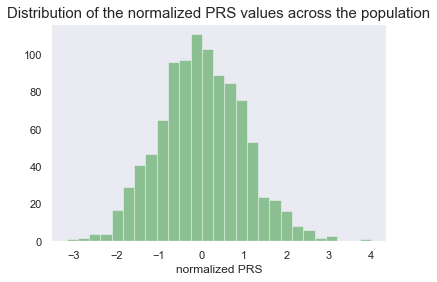

In [8]:
sns.set(color_codes=True)
sns.set_style("dark")

sns.distplot(df_prs["z_PRS"], kde=False, color = "green").set_xlabel("normalized PRS")

plt.title("Distribution of the normalized PRS values across the population", fontsize=15)

**The raincloud plot below showing PRS distributions by population subtype.**

As illustrated in the plot, on average Ashkenazi Jewish have the highest average PRS score and European and Other subtypes are among the lowest.

(In the raincloudplot, each dot represents the PRS value for each individual in the corresponding population subtype. The split-half violin plots show the probability density of the data at different value.)


Text(0.5, 1.0, 'Distributions of PRS scores by Population sub-type')

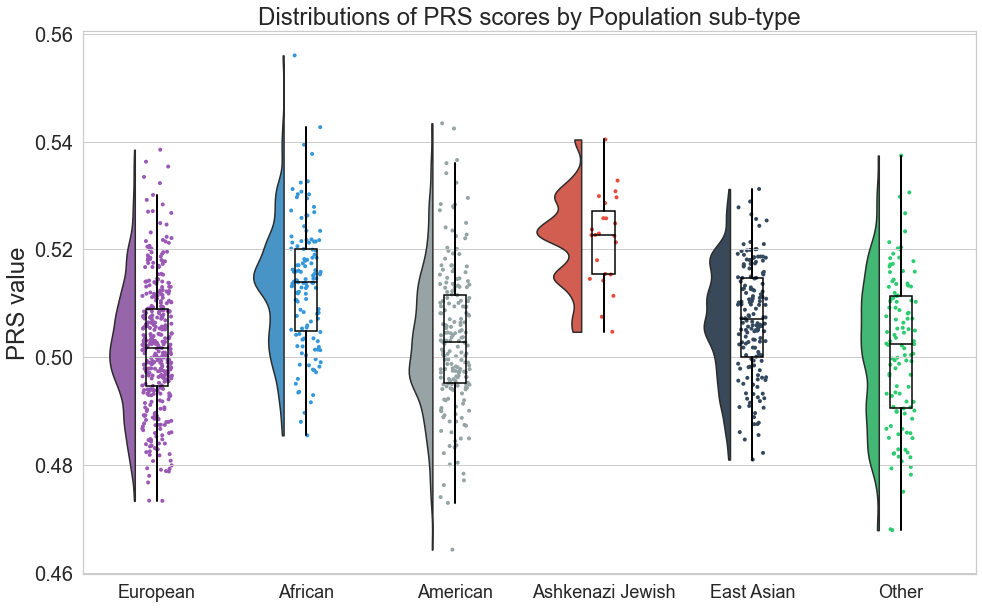

In [9]:
sns.set(style="whitegrid",font_scale=2)

# plotting the clouds
plt.figure(figsize=(16, 10))
ort="v"; 
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
pal = sns.color_palette(flatui)

def rcplot(x, y, order):
    ax=pt.half_violinplot( x = x, y = y, 
                      data = df_prs, 
                      palette = pal,
                      bw = .2, cut = 0.,scale = "area", 
                      width = .6, inner = None,
                      orient = ort, 
                      order = order)

    ax=sns.stripplot( x = x, y = y, 
                data = df_prs, 
                 palette = pal, 
                 edgecolor = "white",
                 size = 4, jitter = 1, zorder = 0, 
                 orient = ort,
                 order= order)

    ax=sns.boxplot( x = x, y = y, 
                data = df_prs,  
                color = "black", 
                width = .15, zorder = 10, showcaps = False,
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=False,
                whiskerprops = {'linewidth':2, "zorder":10},
                saturation = 1, orient = ort,
                order = order)

rcplot("population", "PRS", ['European', 'African', 'American', 'Ashkenazi Jewish', 'East Asian', 'Other'])
    
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.xlabel("")
plt.ylabel("PRS value")
plt.title("Distributions of PRS scores by Population sub-type")

## 1.2 Task II
**Identify the top 5 SNPs in each of the population subtypes that contributes the most to the difference between the average PRS of that population and the average PRS of the European population**


In [10]:
# show the average PRS of each population subtype
df_prs.groupby("population")["PRS"].mean().sort_values()

population
Other               0.501543
European            0.502030
American            0.503438
East Asian          0.506840
African             0.513331
Ashkenazi Jewish    0.521989
Name: PRS, dtype: float64

Here, for each population subtype, we try to identify the top 5 SNPs that contributes the most to the average PRS of the specific population subtype.   

PRS for each individual is calculated as the summation of all of the product of a SNP genotype (the number of risk alleles) with the corresponding weights provided.  The top 5 SNPs would be the ones that give the greatest (average) values of the product of SNP X * Weight, for that population. 

The dataframe 'df_summary' below summarises the top 5 SNPs (in the column 'rsID') associated with the 5 largest (absolute) values of the product of SNP X * Weight, i.e. those giving the most contributions to the computation of average PRS, in each populations subtype (except the European).

In [11]:

df_summary = pd.DataFrame(columns=['rsID', 'abs_wProdSum', 'population', "contribute_rank"])
poptype = ["American", "East Asian", "African", "Ashkenazi Jewish", "Other"]

for subpop in poptype:
    sub_counts = counts[counts["population"] == subpop].drop(["population"], axis=1)
    
    # compute the average product of a specify SNP and its weight across all individuals in that population subtype
    df_wsum = sub_counts.T.mul(np.array(effects["effect_weight"]), axis=0).mean(axis=1)  
    df = pd.DataFrame({"abs_wProdSum": df_wsum.abs().nlargest(5)}).reset_index()
    df.rename(columns={'index': 'rsID'}, inplace=True)
    df["population"] = subpop
    df["contribute_rank"] = df["abs_wProdSum"].rank(ascending=0)
    df_summary = df_summary.append(df)

df_summary

,rsID,abs_wProdSum,population,contribute_rank
0,rs1911708,0.001159,American,1.0
1,rs114343304,0.001158,American,2.0
2,rs147403595,0.001157,American,3.0
3,rs117699264,0.001155,American,4.0
4,rs117962056,0.001147,American,5.0
0,rs11178413,0.001162,East Asian,1.0
1,rs2149218,0.001159,East Asian,2.0
2,rs1911708,0.001159,East Asian,3.0
3,rs112990208,0.001158,East Asian,4.0
4,rs116466727,0.001158,East Asian,5.0


# Part II
## Insights from the User x State matrix

## 2.1 Task I

In [12]:
users_df = readCSV("users_states.csv")
users_df.shape

(364, 334)

In [13]:
users_df = users_df.rename(columns={users_df.columns[0] : "users"})
users_df.set_index("users", inplace= True)

In [14]:
users_df.head(6)

,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,...,state_324,state_325,state_326,state_327,state_328,state_329,state_330,state_331,state_332,state_333
users,,,,,,,,,,,,,,,,,,,,,
user_1,3.0,NaN,2.0,NaN,5.0,NaN,3.0,NaN,4.0,5.0,...,5.0,2.0,NaN,NaN,2.0,4.0,2.0,4.0,3.0,1.0
user_2,2.0,3.0,2.0,3.0,5.0,3.0,3.0,3.0,4.0,5.0,...,5.0,3.0,3.0,3.0,2.0,4.0,2.0,4.0,3.0,1.0
user_3,3.0,4.0,3.0,NaN,3.0,4.0,3.0,NaN,4.0,4.0,...,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0
user_4,3.0,NaN,2.0,NaN,5.0,NaN,3.0,NaN,4.0,5.0,...,5.0,2.0,NaN,NaN,2.0,4.0,2.0,4.0,3.0,1.0
user_5,3.0,3.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,1.0,...,1.0,3.0,3.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0
user_6,3.0,3.0,3.0,3.0,4.0,5.0,1.0,3.0,1.0,1.0,...,1.0,3.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0


**In this section, I will explore this user X state data-set to answer these few questions.**   
     - 1) Is there similarity in users with high proportion of missing 'state' information?  
     - 2) Is there a trend across the 'states' (assuming 'states' possessing some temporal order)?   
     - 3) Finally, can the users be clustered into distinct groups given the 'state' information?    



**To start with, some of the 'state' variables have more than 50% of missing data (~182 out of 364 users). There are 12 'state' variables fulfilling this criteria.**

In [15]:
col2check = []
for col in users_df.columns[0:]: 
    if users_df[col].isnull().sum() > 180:
        print(col, users_df[col].isnull().sum())
        col2check.append(col)

len(col2check)

state_4 240
state_8 240
state_46 240
state_103 240
state_146 240
state_163 240
state_218 240
state_229 240
state_245 240
state_269 240
state_295 240
state_313 240


12

**Then, some of the users also have more than 50% of missing data (~166 out of 333 possible 'state' variables). There are 18 such users.**

In [16]:
row2check = []
for i in range(0,len(users_df.index)):
    if users_df.iloc[i].isnull().sum() > 150:
        print(users_df.index[i], users_df.iloc[i].isnull().sum())
        row2check.append(users_df.index[i])

print("no. of users with high proportion of missing data: ", len(row2check))

user_20 239
user_27 239
user_81 239
user_84 262
user_154 215
user_176 262
user_190 280
user_201 262
user_226 184
user_233 259
user_258 239
user_301 168
user_312 262
user_322 217
user_333 220
user_334 203
user_347 203
user_352 262
no. of users with high proportion of missing data:  18


### Is there a common pattern in missing data among users with high proportion of missing data?
To look further into the data of these users specifically, there doesn't seem to be any observable pattern of their missing data across the 'state' variables. 

The bar plot below highlights the 'state' variables that have missing values from more than 15, out of 18, users who had missed more than 50% of data-points. There are in fact 112 such variables. There is no clear pattern that users tend to have missing data in some specific 'states'.

Given the information about the quality and charactersitics of the 'state' variables are limited in this example, here I should there is no quality differences between them. Future strategies probably should aim to increase engagement of users in general, but not necessarily targeting specific states.

No. of variables with missing data from > 15 users among the 18 users with most missing data:  112


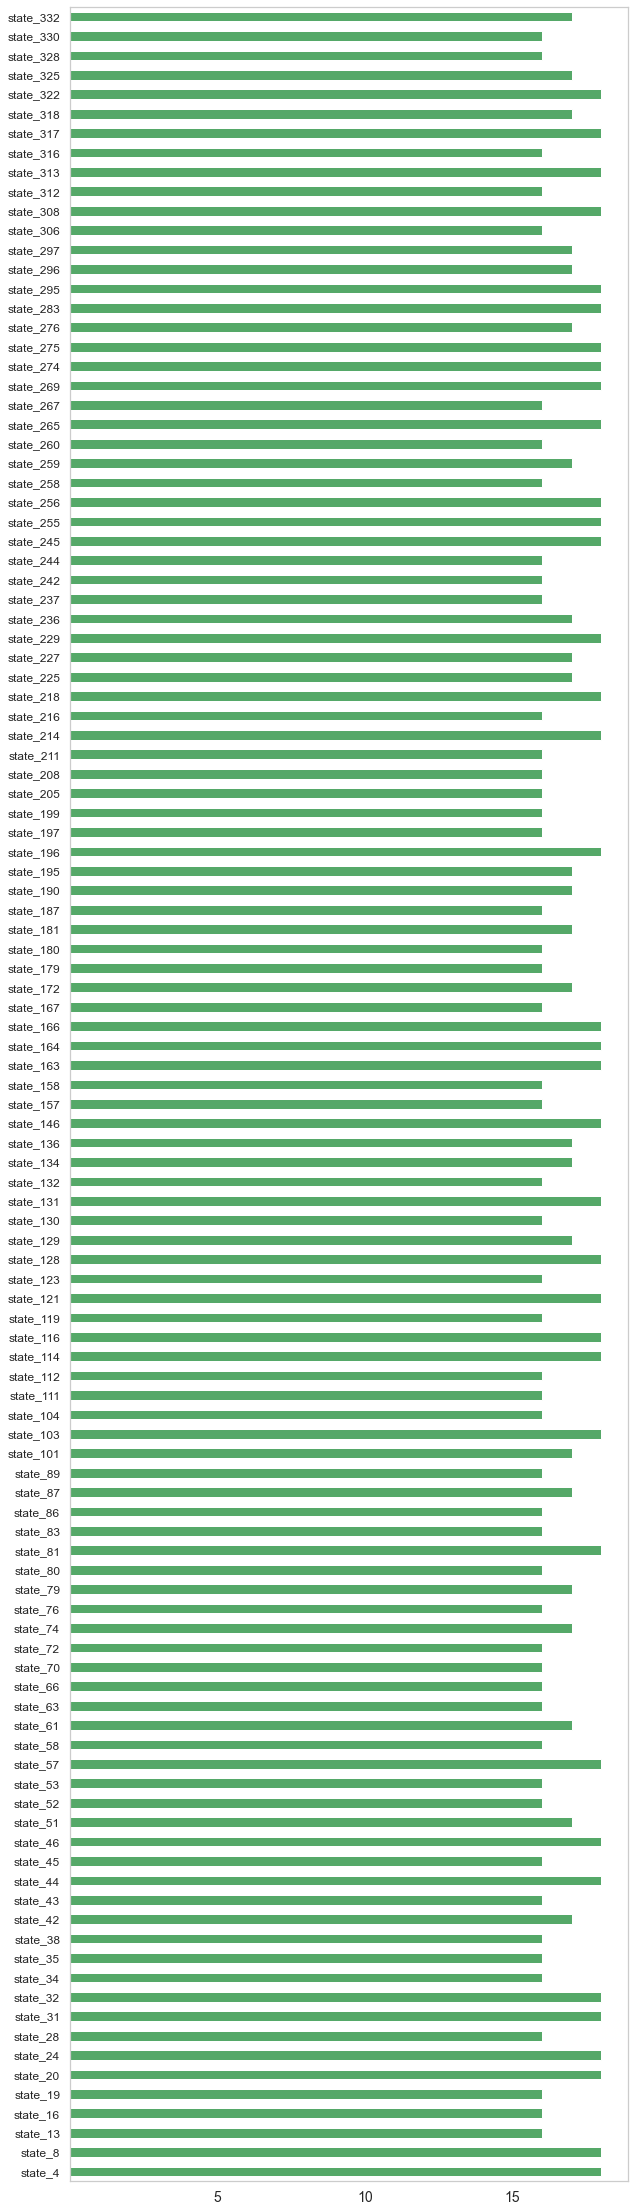

In [17]:
hiMissUser = users_df.loc[row2check].isnull().sum().to_frame('nNull')
hiMissUser = hiMissUser[hiMissUser.nNull > 15]

print("No. of variables with missing data from > 15 users among the 18 users with most missing data: ",
     len(hiMissUser[hiMissUser.nNull > 15]))

hiMissUser.plot(kind='barh', figsize=(10,40), color="g")

plt.yticks(fontsize=12)
plt.xticks([5, 10, 15], fontsize=14)
plt.legend().set_visible(False)
plt.grid(False)
plt.show()

### Is there any trend across the 'state' variables?
Here, there is an assumption that the 'state' variables carry some kind of temporal order (of course, it is just an assumption as no further information was given on this).

The line plot below may suggest that there is no obvious (increasing/decreasing) trend across the 'states', but there appears to be potential seasonal changes (systematic fluctuation over periods). A time-series analysis can be applied in the future to verify this possibility. 


In [18]:
users_df.drop(row2check, axis=0).describe()

,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,...,state_324,state_325,state_326,state_327,state_328,state_329,state_330,state_331,state_332,state_333
count,344.000000,292.000000,343.000000,124.000000,344.000000,324.000000,346.000000,124.000000,346.000000,346.000000,...,344.000000,341.000000,328.000000,293.000000,344.000000,335.000000,345.000000,346.000000,343.000000,346.000000
mean,2.357558,2.321918,3.131195,2.951613,2.662791,3.722222,2.514451,2.951613,3.471098,3.742775,...,3.607558,3.527859,2.771341,2.303754,1.773256,2.319403,2.402899,3.248555,2.510204,1.404624
std,0.813552,1.206711,0.896869,0.215453,0.973233,0.881527,0.858762,0.215453,1.428703,1.545547,...,1.546199,1.018917,0.908422,1.210635,0.861069,1.187288,0.894097,1.392136,0.861310,0.666709
min,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000
50%,2.000000,2.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,4.000000,...,4.000000,4.000000,3.000000,2.000000,2.000000,2.000000,2.000000,4.000000,3.000000,1.000000
75%,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,5.000000,...,5.000000,4.000000,3.000000,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000
max,4.000000,5.000000,5.000000,3.000000,5.000000,5.000000,3.000000,3.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000


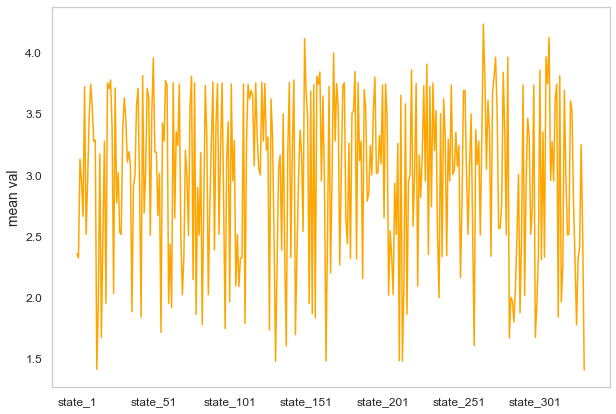

In [19]:
df_state_mV =  users_df.drop(row2check, axis=0).mean().to_frame('mValue')

df_state_mV.plot(figsize=(10,7), color='orange')

plt.ylabel('mean val', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend().set_visible(False)
plt.grid(False)
plt.show()

###  Finally, can the users be clustered into distinct groups given the 'state' variables? 
I will run a couple of k-means clustering analysis models here, including 1) using the raw data and 2) using the data with reduced dimensions (achieved with Principal Component Analysis)

In [20]:
# create and work on a new copy of users_df
newusers_df = users_df.copy()


This simulated data-set has a lot of missing data (probably intended). In reality, it would be important to investigate the nature of these missing data, for example to check the characteristic of the variables (e.g. whether a variable represents a sensitive question that users generally want to avoid), or to check if the missing data are systematic or random. 

With the few descriptive analyses I have taken above, there doesn't seem to be any clear pattern that users tend to have missing data in some specific 'states'. In this case, for the rest of the clustering analysis, I will remove the 'state' variable columns that have more than 50% of missing data and also the users that have more than 50% of missing data

For the remaining missing values, I will impute then with the median of each 'state' variable. This method is a bit conservative as it reduces the overall variance of the data. (Other approaches for data imputation can be a predictive modelling with the help of other features in the dataset. However, given that only limited information is provided in the current dataset, this approach may not be most relevant).



In [21]:
# here we drop the few columns with more than 50% of missing data, and then the 'users' with more than 50% missing data
newusers_df.drop(col2check, axis=1, inplace=True) 
newusers_df.drop(row2check, axis=0, inplace=True)


In [22]:
from sklearn.impute import SimpleImputer

# use the SimpleImputer function to substitute the rest of missing values with 'median'
imp_med = SimpleImputer(missing_values=np.nan, strategy="median")
k_med = pd.DataFrame(imp_med.fit_transform(newusers_df))
k_med.columns = newusers_df.columns
k_med.set_index(newusers_df.index, inplace=True)




### The first k-means clustering model with raw data ('state' variables)

In [23]:
from sklearn.cluster import KMeans

X = k_med.values

def kmeans_test(data, min, max):
    wcss=[]

    #this loop will fit the k-means algorithm to our data and 
    #second, compute the within cluster sum of squares 
    for i in range(min, max+1): 
         #i above ranges between the min and max values provided
         kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10, random_state=13 )
         kmeans.fit(data)
    
         #appended to the wcss list the sum of squared distances of samples #to their closest cluster center.
         wcss.append(kmeans.inertia_)
    return wcss
            
wcss = kmeans_test(X, 1, 10)

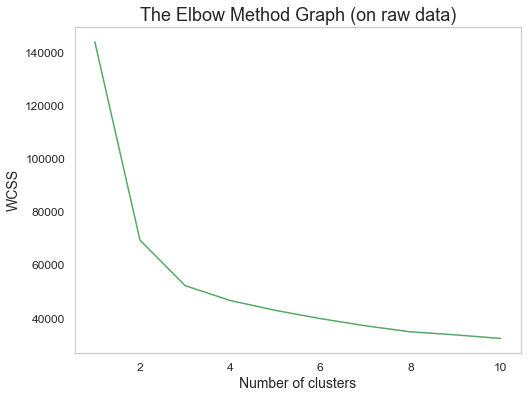

In [24]:
# Plot an elbow graph to see the changes of these sum of squred distances
def elbow_graph(min, max, wcss_list, title):
    plt.figure(figsize=(8,6))
    plt.plot(range(min,max+1),wcss_list, color='g')
    plt.title(title, fontsize=18)
    plt.xlabel('Number of clusters', fontsize=14)
    plt.ylabel('WCSS', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.grid(False)
    plt.show()
    
elbow_graph(1, 10, wcss, 'The Elbow Method Graph (on raw data)')

According to the Elbow graph above, it seems that there are 3 possible clusters in the data-set

### The second k-means clustering model with Principal Component outputs
Principal Component Analysis is not only a useful approach for reducing down the number of features and project them onto a lower-dimensional space, but also good for data visualisation (of high-dimensional data)

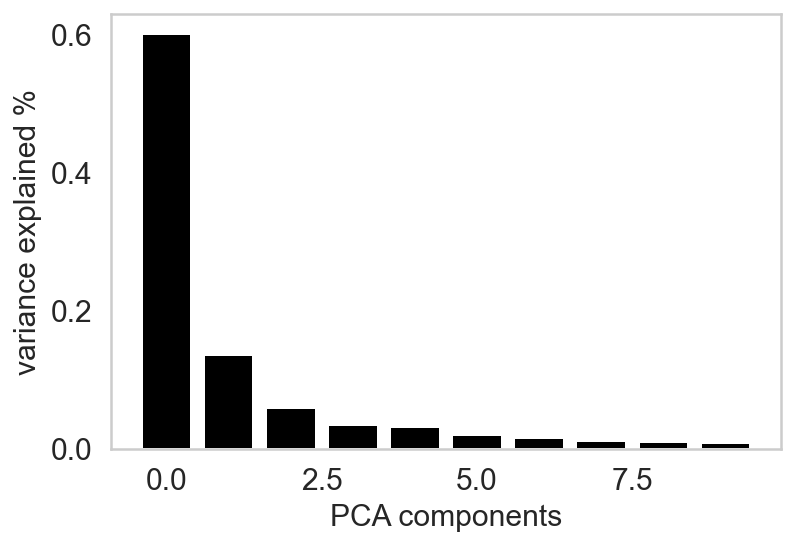

In [25]:
from sklearn.decomposition import PCA
%config InlineBackend.figure_format='retina'

# Create a PCA instance
pca = PCA(n_components = 10)
prinCom = pca.fit_transform(X)

#Plot the explained variances
features = range(pca.n_components)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA components', fontsize=15)
plt.ylabel('variance explained %', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(False)


The figure above shows that the first three components explain the majority of the variance in the data (and it is where the trend starts to flatten out). 

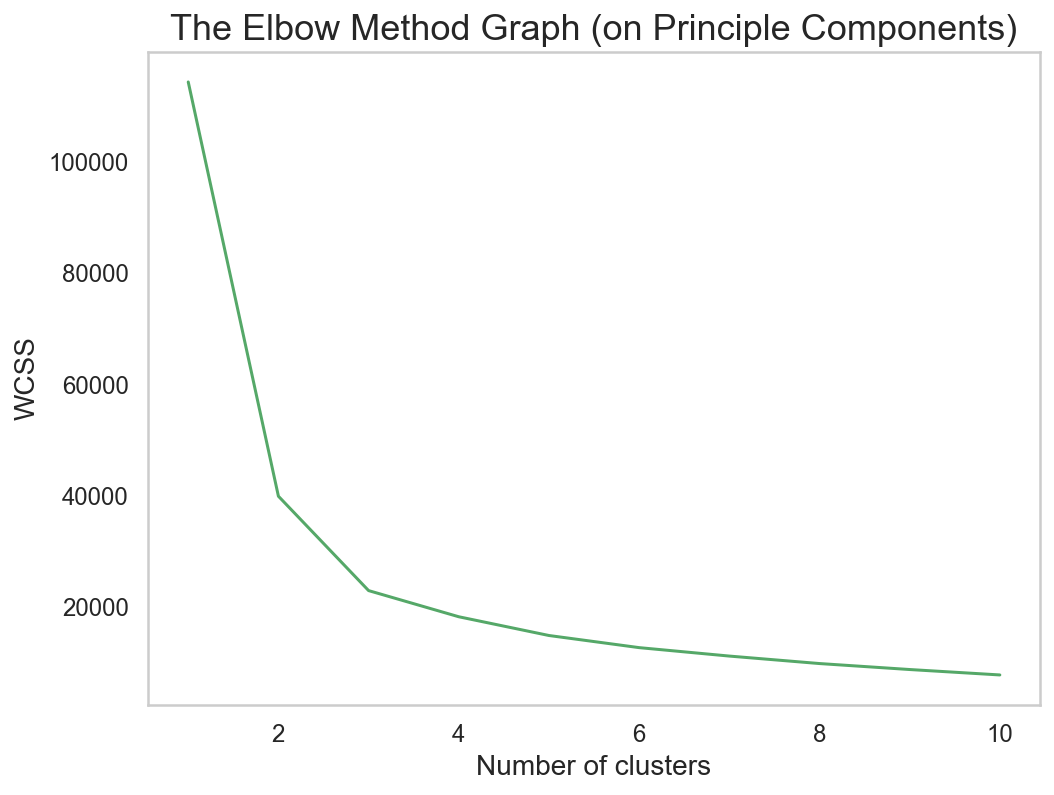

In [26]:
# Save components to DataFrame
PCA_df = pd.DataFrame(prinCom)
PCA_df

# using the functions created above to run the k-means clustering analysis again on the principal component scores
# here I only use the first three principal components
wcss = kmeans_test(PCA_df.iloc[:,:3], 1, 10) 
# use the elbow_graph function created above to plot the graph
elbow_graph(1, 10, wcss, 'The Elbow Method Graph (on Principle Components)')


Again, the analysis suggests 3 possible clusters in the data-set

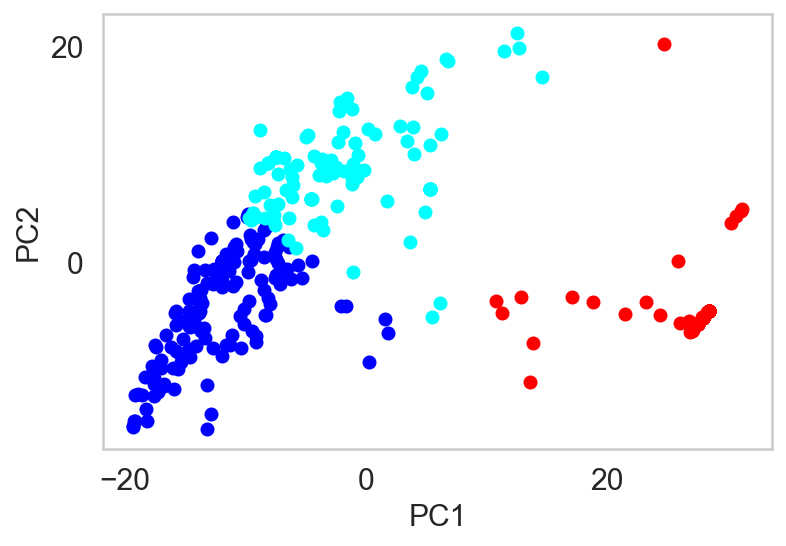

In [27]:
# plot data from the first two principal components and their relationship with the three possible clustes
df_pred = pd.DataFrame(PCA_df.iloc[:,:3]).rename(columns = {0:'PC1', 1:'PC2', 2:'PC3'})
kmeans = KMeans(n_clusters=3, init ='k-means++', max_iter=300,  n_init=10, random_state = 13)
df_pred['pCluster'] = kmeans.fit_predict(PCA_df.iloc[:,:3])

plt.scatter(df_pred.PC1[df_pred["pCluster"]==0], df_pred.PC2[df_pred["pCluster"]==0], color='red', label ='Cluster 1')
plt.scatter(df_pred.PC1[df_pred["pCluster"]==1], df_pred.PC2[df_pred["pCluster"]==1], color='blue', label ='Cluster 2')
plt.scatter(df_pred.PC1[df_pred["pCluster"]==2], df_pred.PC2[df_pred["pCluster"]==2], color='cyan', label ='Cluster 3')


plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(False)

The current preliminary clustering analysis (using a k-means approach) suggests there are three 3 possible clusters among our users based on their 'state' variable data. Further investigation, using other approaches such as mean-shift clustering, can be easily applied to verify these current results. 
In contrast to K-means clustering, an approach such as mean-shift clustering does not require pre-selection of the number of clusters as the algorithm automatically discovers this.

With the current data-set, we only have limited information about the 'state' variables related to the users. If we have other details such as some users' charactersitic information or users' behaviour data, we can probably test other prediction models to make inferences, which may be useful for recommendataion on some behavioural interventaion.